## Cummulative edges method

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle as pkl
import scipy.interpolate
import time
from scipy.signal import savgol_filter
import copy

import statistics 
from scipy.signal import find_peaks

In [2]:
def checkbins(pcounts, pbins):
    issueindex = []
    for x in range(len(pbins)-1):
        if pbins[x] != pbins[x-1] +1:
            issueindex.append(x)
    if len(issueindex) != 0:
        #take the last index in the list and begin the lists there
        lastindex = issueindex[-1]
        bins = pbins[lastindex:]
        counts = pcounts[lastindex:]
    else: 
        counts = pcounts
        bins = pbins 
    return counts, bins
    
def load_dataset(amp): #load and prepares the data
    superhist = "histdataset1.pkl"
    with open(superhist, "rb") as f:
        ds = pkl.load(f)
    countarr = ds[amp] #strictly the compiled im_arr of all the images 
    mbins = np.arange(26500, 26500+len(countarr)) #built into the pkl file
    mincounts = 150
    scounts = countarr > mincounts #bin indexes of sufficient counts
    pcounts = countarr[scounts]
    pbins = mbins[scounts]
    ##check that bins have no gaps; it will cause issues
    counts, bins = checkbins(pcounts, pbins)
    return counts, bins

def filter_dataset(counts, bins):
    smoothed = savgol_filter(counts, 33, 3) #apply filter
    cumulsum = np.cumsum(smoothed) #make the cumulative sum
    #by construction of the method, cumulative sum values lie on the right edge of the bin (ie bins +1)
    cs = scipy.interpolate.CubicSpline(bins +1, cumulsum) #spline fitting for the cumulative values 
    #i have the values attached to the left edge 
    #print("smoothed sum - counts", cumulsum[-1] - sum(counts))
    return cs 

def examineinl(edges, edgemethodname, start): #here binsnum is binnumbers 
    inlbins = np.arange(start, start+len(edges)-1)
    idealmids = 0.5 + inlbins
    adcmids = [sum(i) for i in zip(edges[1:], edges[:-1])] #add together elements
    adcmids[:] = [x / 2 for x in adcmids] #find their mean, verified 3 entires, sufficient
    arraymids = np.array(adcmids)*(-1) 
    inl = [sum(i) for i in zip(idealmids, arraymids)]
    plt.plot(inlbins, inl, color='black', label='inl')
    plt.title(f'{edgemethodname} inl by bin number')
    plt.xlabel("bin number")
    plt.ylabel("inl")
    plt.legend()
    plt.grid()
    plt.show()
    return inl 

def examinednl(edges, start):
    widths = []
    for x in range(len(edges)-1):
        width = edges[x+1]- edges[x]
        widths.append(width)
    dnl = np.array(widths) -1  #ideal width =1
    plt.scatter(np.arange(start, start+len(dnl)), dnl, s=5, label='dnl')
    plt.title('dnl by bin')
    plt.xlabel("bin")
    plt.ylabel("dnl")
    plt.grid()
    plt.show()
    return dnl

def makenarrow(bcvar, right, left):
    width = right - left
    width *= (1-bcvar) #reduce the width of the bin 
    right = width + left 
    bcvar *= 0.85 #make the change amount reduced by 85% 
    return right, bcvar
    
def makewide(bcvar, right, left): #function increases the bin width 
    width = right - left
    width *= (1+bcvar) #increase the width of the bin 
    right = width + left 
    bcvar *= 0.85 
    return right, bcvar

def checkstartingbin(start, bins): #verifies data exists for starting bin 
    if start < bins[0]:
        print("binning cannot start at specified value")
        print("binning can start at", bins[0]) 
        raise KeyboardInterrupt

def cumulativeedges(counts, bins, spline, un, start):
    st = time.time() #time the algorithm ? 
    checkstartingbin(start, bins)
    
    edges = [start] #edges start at leftmost bin

    residualcumsum = spline(start) #the cumsum of the bins not included in the binning 
    firstcount = np.argwhere(bins == start) #start using values where specified     
    rightgoals = np.cumsum(counts[firstcount[0][0]:]) #the cumsum of the counts to be achieved; ie the right edge
    goals = rightgoals + residualcumsum #add in the ped of the spline discarded 

    for a in range(len(goals)): 
        left = edges[-1]
        if left > 102999.5: #prevent interpolation beyond what we have for bins
            break
        right = left + 1 #standard bin width = 1
        cv = spline(right) #current value, based on current right edge
        bcvar = 0.25 #bin change variable (start with 25% change)  
        x =0
        while len(edges) != a+2: 
            if goals[a]-un < cv < goals[a] + un: #specify the requirement
                edges.append(right)
            
            elif cv < goals[a]: #bin is too small, widen right edge
                right, bcvar = makewide(bcvar, right, left)
                cv = spline(right)
                if x >1500:
                    print("help small", a)
            elif cv > goals[a]:  #bin is too big, reduce right edge
                right, bcvar = makenarrow(bcvar, right, left)
                cv = spline(right)
                if x >1500:
                    print("help big", a)
            x+= 1
    end = time.time()
    print("the computation time is", end-st)
    return edges

## Make edges beginning at 30k

In [3]:
counts, bins = load_dataset("C01")
cs = filter_dataset(counts, bins)

the computation time is 11.866420984268188


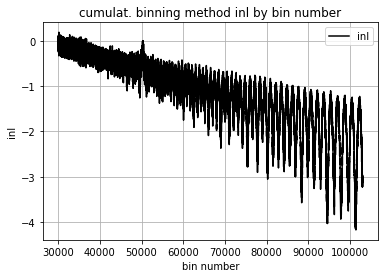

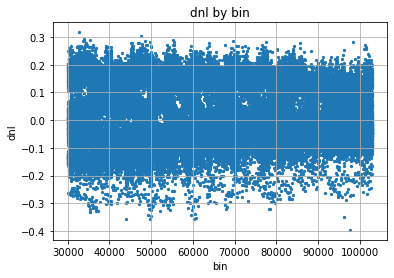

In [4]:
edges = cumulativeedges(counts, bins, cs, 1, 30000)
inl = examineinl(edges, "cumulat. binning method", 30000)
dnl = examinednl(edges, 30000)

beginning at 30k we have dnl between +/- 0.35 an inl increase of -4 over 70k bins, which is not too bad 

## try binning beginning at 27k 

the computation time is 12.783810138702393


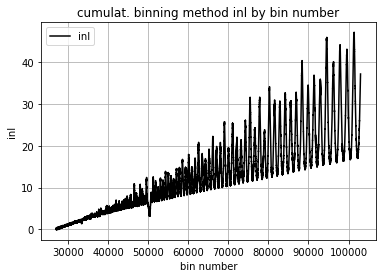

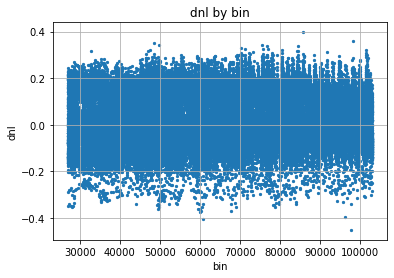

In [5]:
edges2 = cumulativeedges(counts, bins, cs, 1, 27000)
inl2 = examineinl(edges2, "cumulat. binning method", 27000)
dnl2 = examinednl(edges2, 27000)

(-1.0, 5.0)

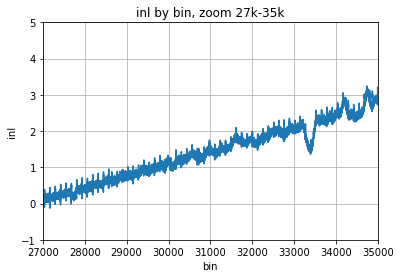

In [6]:
plt.plot(np.arange(27000, 27000+len(inl2)), inl2)
plt.xlim(27000, 35000)
plt.xlabel("bin")
plt.ylabel("inl")
plt.title("inl by bin, zoom 27k-35k")
plt.grid()
plt.ylim(-1,5)

This behavor is rather different than starting the binnning at 30k. A growth of 4 over 8k bins (when starting at 27k vs 4 over 73k). Over 1k bins we have about 0.5 inl growth

## 2. Find a minimum that this makes edges for
recommendation for 26.7k but data begins at 26.707
starting at the first bin, yields an issue in the code. 

In [62]:
#startingbin = bins[0]
#edgesfirst = cumulativeedges(counts, bins, cs, 1, startingbin)
print("too large, indef loop")

too large, indef loop


upon some(now deleted trial runs of this, we can starting binning using the method as written at 26714. Otherwise we continue to get this erorr. Continue to see how the edges look in the early region.

the computation time is 12.795487880706787


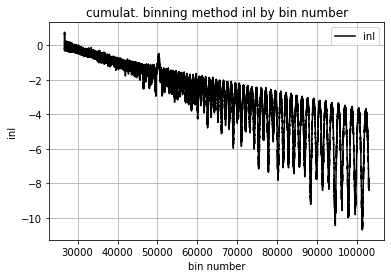

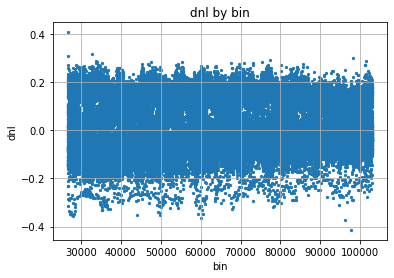

In [8]:
startingbin = 26716
edges4 = cumulativeedges(counts, bins, cs, 1, startingbin)
inl4 = examineinl(edges4, "cumulat. binning method", startingbin)
dnl4 = examinednl(edges4, startingbin)

the computation time is 12.873674154281616


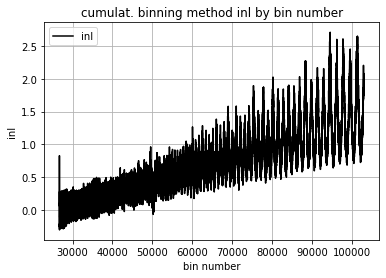

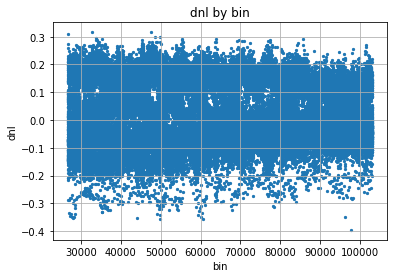

In [9]:
startingbin = 26717
edges3 = cumulativeedges(counts, bins, cs, 1, startingbin)
inl3 = examineinl(edges3, "cumulat. binning method", startingbin)
dnl3 = examinednl(edges3, startingbin)

I am concerned about how including 1 more bin changes the inl so dramatically. There is also an issue with the binning method below index 26714 (I believe the bins would need to be exceptionally small to fit; I will investigate later). See how changing by 4 bins affects the inl

In [10]:
def getinl(edges, start): #here binsnum is binnumbers 
    inlbins = np.arange(start, start+len(edges)-1)
    idealmids = 0.5 + inlbins
    adcmids = [sum(i) for i in zip(edges[1:], edges[:-1])] #add together elements
    adcmids[:] = [x / 2 for x in adcmids] #find their mean, verified 3 entires, sufficient
    arraymids = np.array(adcmids)*(-1) 
    inl = [sum(i) for i in zip(idealmids, arraymids)]
    return inl 

def getdnl(edges, start):
    widths = []
    for x in range(len(edges)-1):
        width = edges[x+1]- edges[x]
        widths.append(width)
    dnl = np.array(widths) -1  #ideal width =1
    return dnl

def plotmanyinls(startingvals, counts, bins, cs): 
    dnls = {}
    fig = plt.figure(figsize=(15,12))
    axes = fig.subplots(2,2, sharex=True, sharey=True)
    fig.suptitle('inl by starting bin', fontsize=24)
    plt.setp(axes[1,0], xlabel = 'bin', ylabel = 'inl') #fix the labels so on all of them 
    plt.setp(axes[0,0], ylabel = 'inl')
    a = 0
    b = 0 
    c = 0
    while c < 2: 
        plt.setp(axes[1,c], xlabel = 'bin')
        c += 1 
    for n in range(len(startingvals)): 
        edges = cumulativeedges(counts, bins, cs, 1, startingvals[n])
        inl = getinl(edges, startingvals[n])
        dnl = getdnl(edges, startingvals[n])
        dnls[startingvals[n]] = dnl
        print("Binning beginning at", startingvals[n], "has max and min inl vals", max(inl), min(inl))
        xvals = np.arange(startingvals[n], startingvals[n] + len(inl))
        axes[a,b].plot(xvals, inl)
        axes[a,b].set_title(f"inl by bin starting at {startingvals[n]}")
        axes[a,b].grid()
        if a < 1 : 
            a +=1 
        else: 
            b +=1 
            a = 0
    return dnls 
            
def plotmanydnl(startingvals, dnls):
    fig = plt.figure(figsize=(10,8))
    axes = fig.subplots(2,2, sharex=True, sharey=True)
    fig.suptitle('dnl by starting bin', fontsize=24)
    plt.setp(axes[1,0], xlabel = 'bin', ylabel = 'dnl') #fix the labels so on all of them 
    plt.setp(axes[0,0], ylabel = 'dnl')
    a = 0
    b = 0 
    c = 0
    while c < 2: 
        plt.setp(axes[1,c], xlabel = 'bin')
        c += 1 
    for n in range(len(startingvals)): 
        dnl = dnls[startingvals[n]]
        xvals = np.arange(startingvals[n], startingvals[n] + len(dnl))
        axes[a,b].scatter(xvals, dnl, s=5)
        axes[a,b].set_title(f"dnl by bin starting at {startingvals[n]}")
        axes[a,b].grid()
        if a < 1 : 
            a +=1 
        else: 
            b +=1 
            a = 0

the computation time is 13.316318988800049
Binning beginning at 26714 has max and min inl vals 0.5660866639118467 -77.49836160193081
the computation time is 13.296419620513916
Binning beginning at 26715 has max and min inl vals 0.6537656271029846 -40.53292291366961
the computation time is 13.408030986785889
Binning beginning at 26716 has max and min inl vals 0.7656693828539574 -10.702538091078168
the computation time is 13.467603921890259
Binning beginning at 26717 has max and min inl vals 2.7091357121244073 -0.30269322735694004


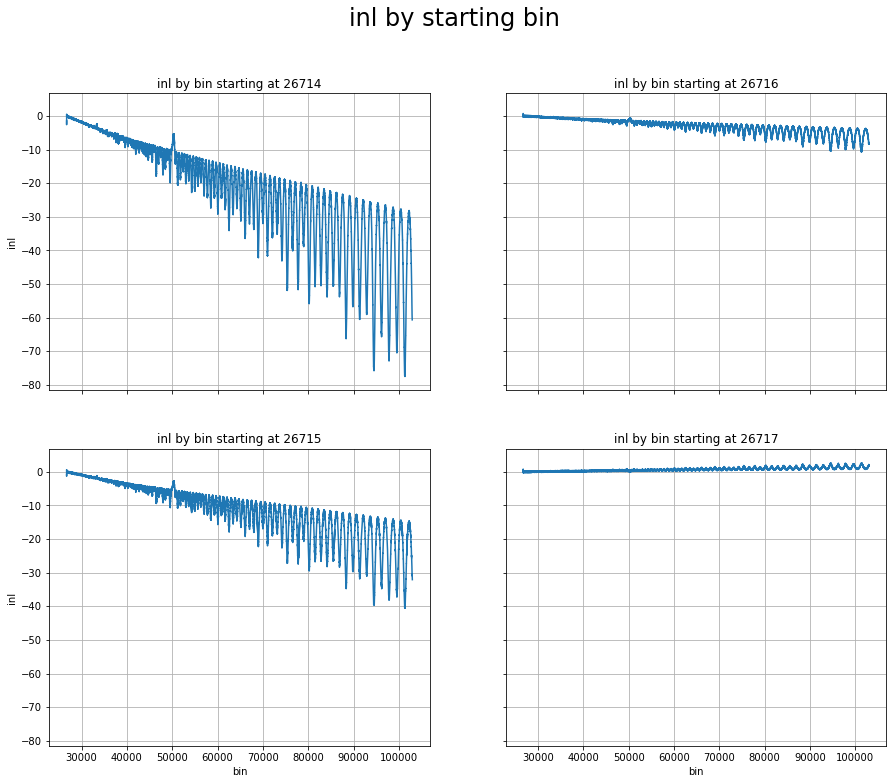

In [11]:
startingvals = np.arange(26714, 26718)
origninaldnls = plotmanyinls(startingvals, counts, bins, cs)

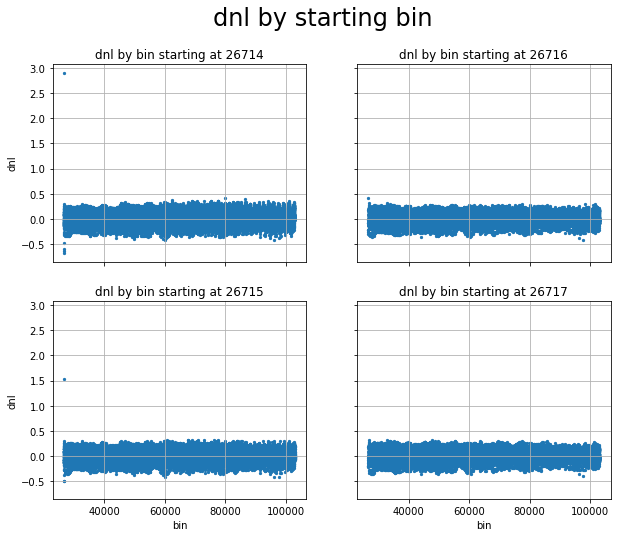

In [12]:
plotmanydnl(startingvals, origninaldnls)

==> getting varied responses depending on the commencing bin: indicates that something is amiss. Also the dnl has some variability in early bins as well 

## 1. Determine what is happening in the low bins, which causes us to get error when running

In [13]:
counts, bins = load_dataset("C01")
cs = filter_dataset(counts, bins)

In [14]:
smoothed =savgol_filter(counts, 33, 3)
print(bins[:10])
print(smoothed[:10])
print(counts[:10])
print("the smoothed (and spline) yields a negative value for some of bins 26713-26718") 

[26707 26708 26709 26710 26711 26712 26713 26714 26715 26716]
[ 41242.66301672  16491.15311731  -2221.8218369  -15233.54029931
 -22881.28072334 -25502.3215624  -23433.94126991 -17013.41829928
  -6578.03110394   7534.94186272]
[  195   421   514   825  1507  2547  3524  5655 11784 15399]
the smoothed (and spline) yields a negative value for some of bins 26713-26718


issue is that the smoothed/spline is negative here; figure out how to fix this
this means that the savgol is yielding negative values as the spline is forced to fit the cumulative sum. Plot the savgol filter in the affected region to see what is happening.

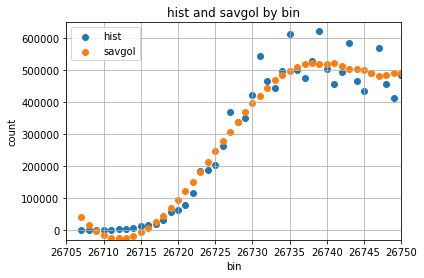

In [15]:
counts, bins = load_dataset("C01")
plt.scatter(bins, counts, label='hist')
plt.scatter(bins, smoothed, label='savgol')
plt.title("hist and savgol by bin")
plt.ylabel("count")
plt.xlabel("bin")
plt.xlim(26705, 26750)
plt.ylim(-3e4, 6.5e5)
plt.legend()
plt.grid()

Negative spline for 26713-26718 explains why there is a wildly different result when we commence the binning between 26714 and 26717, and explains the large dnl for these bins, as the method would require the bin to be super wide since the spline yields a negative value for width of 4 bins. This therefore affects the subsequent bins. 

Solution, fit the spline exclusively to positive filtered values 

In [16]:
def filter_dataset_adjust_new(counts, bins): #can replace the old function with this
    smoothed = savgol_filter(counts, 33, 3) #apply filter
    # require that the result of smoothed > 0 
    positive = smoothed > 0
    positivesmoothed = smoothed[positive]
    positivebins = bins[positive]
    # remove any jumps in the dataset 
    filtered, filtbins = checkbins(positivesmoothed, positivebins) #use same function as before
    #now fit the spline to the cumulative sum of the filtered values greater than zero 
    cumulativesum = np.cumsum(filtered)
    cs = scipy.interpolate.CubicSpline(filtbins +1, cumulativesum) #have right edge
    #remove any counts before where we have positive values from the savgol 
    validcounts = counts[len(bins)-len(filtbins):] 
    return cs, validcounts, filtbins, filtered  

#returns cs, counts, bins (but cut to the proper length)

In [17]:
csnew, validcounts, filtbins, filtered = filter_dataset_adjust_new(counts, bins)

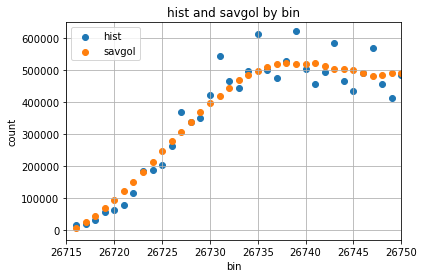

In [18]:
plt.scatter(filtbins, validcounts, label='hist')
plt.scatter(filtbins, filtered, label='savgol')
plt.title("hist and savgol by bin")
plt.ylabel("count")
plt.xlabel("bin")
plt.legend()
plt.xlim(26715, 26750)
plt.ylim(-3e4, 6.5e5)
plt.grid()

can see that this method removes the negative smoothed, and therefore removed any negative values in the spline fitting

## Examine how this fix plays into the binning method

the below two chunks are how to use the above version

In [19]:
counts, bins = load_dataset("C01")
csnew, validcounts, filtbins, filtered = filter_dataset_adjust_new(counts, bins)

the computation time is 11.891010046005249


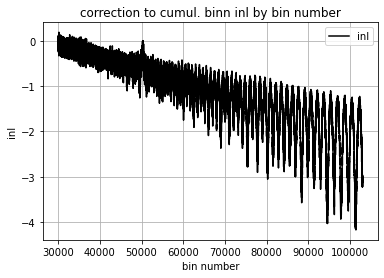

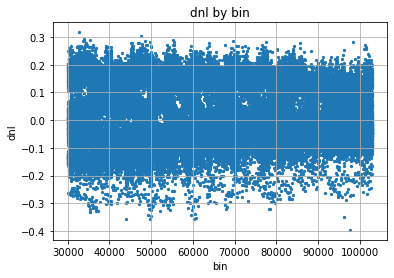

In [20]:
newedges = cumulativeedges(validcounts, filtbins, csnew, 1, 30000)
newinl = examineinl(newedges, "correction to cumul. binn", 30000)
newdnl = examinednl(newedges, 30000)

no change in inl when binning begins at 30k. Check earlier binning and see if this solves the variability issue. 

the computation time is 13.399160146713257
Binning beginning at 26716 has max and min inl vals 0.7635797316615935 -11.140306265588151
the computation time is 13.413317918777466
Binning beginning at 26717 has max and min inl vals 2.709134537828504 -0.30269361355385627
the computation time is 13.386210918426514
Binning beginning at 26718 has max and min inl vals 0.7919085418398026 -5.247779857279966
the computation time is 13.436939001083374
Binning beginning at 26719 has max and min inl vals 0.6917683845094871 -26.068800759487203


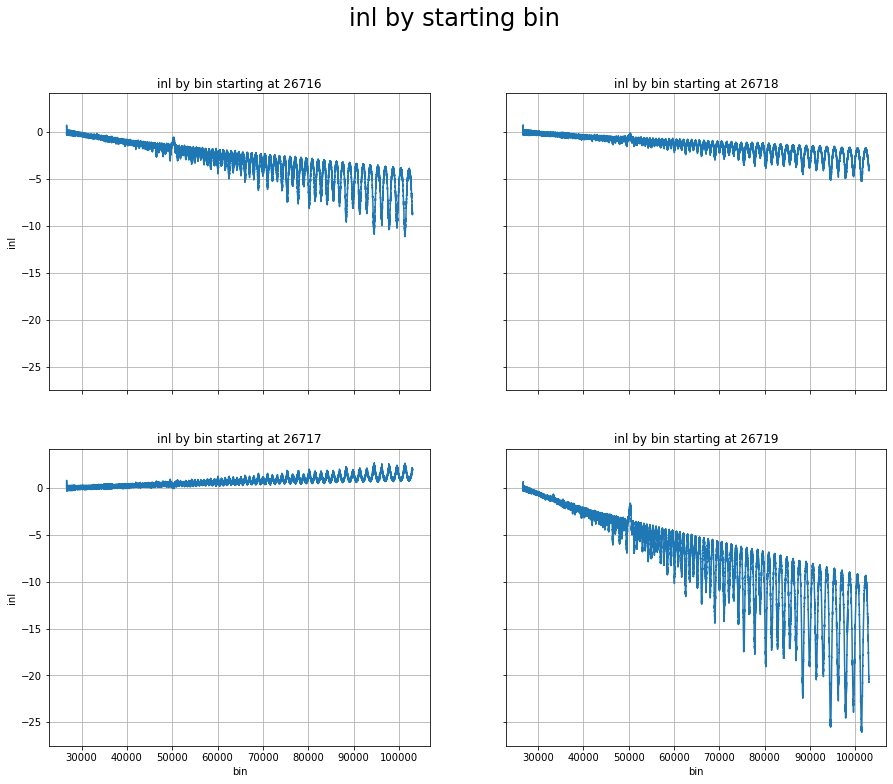

In [21]:
startingvals = np.arange(26716, 26720)
dnls = plotmanyinls(startingvals, validcounts ,filtbins, csnew)

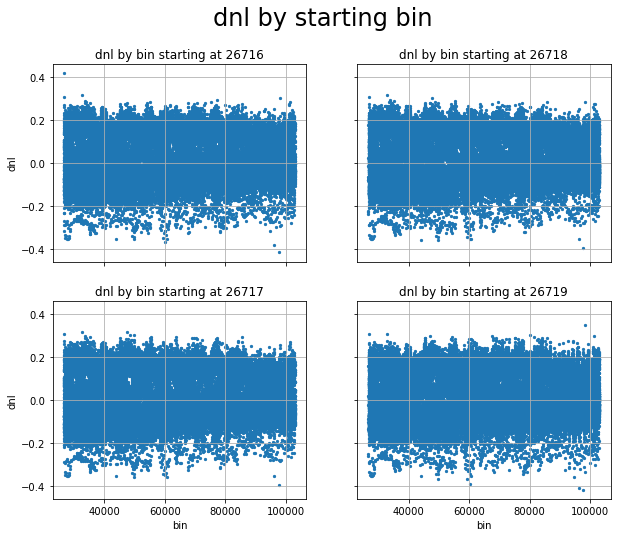

In [22]:
startingvals = np.arange(26716, 26720)
plotmanydnl(startingvals, dnls)

so making the distribution exclusively positive does allow us to start the binning at any point (as we threw out bins with negative values). However it does not change that adding a new bin wildy changes the inl over the entire range. Also we now do not see any values of dnl abouve 0.4 (ish) in most cases. 

Implement this change going forward and use it for the rest of the analysis

## 2. Examine later codes for starting bins to see if the stabilty comes out somewhere

the computation time is 13.316166877746582
Binning beginning at 26756 has max and min inl vals 63.784851968084695 -0.24721218829290592
the computation time is 13.308712005615234
Binning beginning at 26757 has max and min inl vals 0.277094836881588 -3.063900965222274
the computation time is 13.218078136444092
Binning beginning at 26758 has max and min inl vals 0.13077711459845887 -176.407891346229
the computation time is 13.234561681747437
Binning beginning at 26759 has max and min inl vals 0.10243832421838306 -208.65707251422282


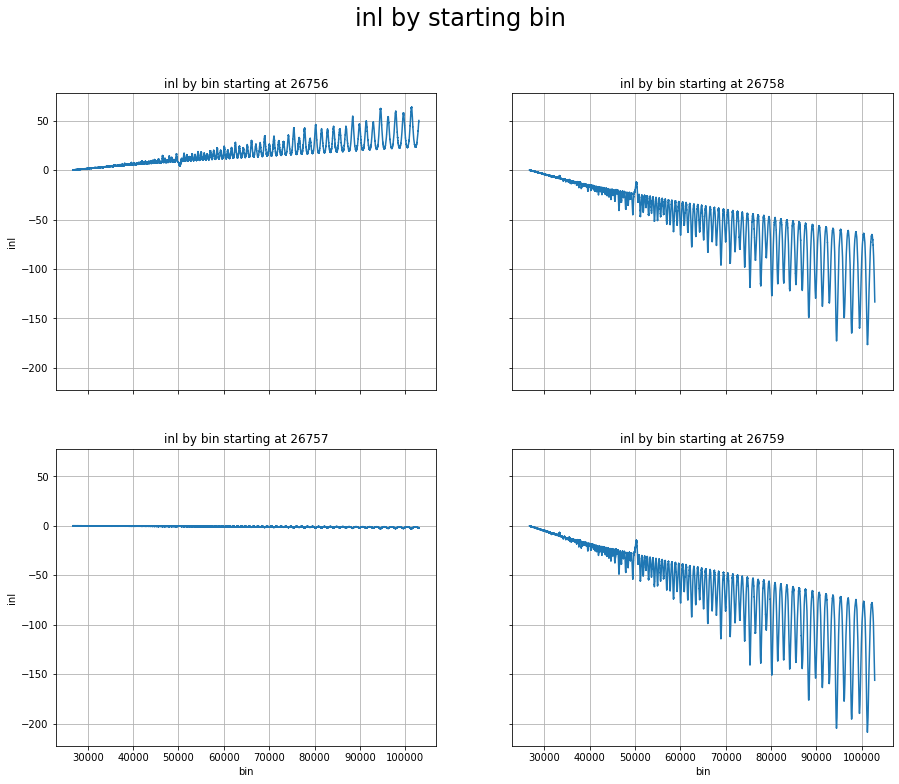

In [23]:
#bins start at 26716
startingvals = np.arange(26756, 26760)
dnls = plotmanyinls(startingvals, validcounts ,filtbins, csnew)

the computation time is 12.752118110656738


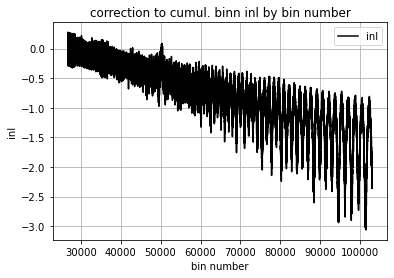

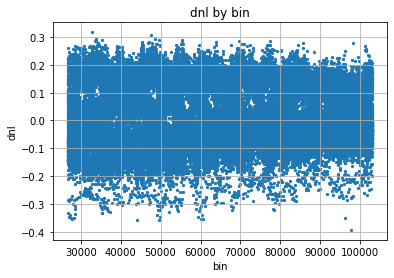

In [24]:
newedges = cumulativeedges(validcounts, filtbins, csnew, 1, 26757)
newinl = examineinl(newedges, "correction to cumul. binn", 26757)
newdnl = examinednl(newedges, 26757)

the computation time is 12.893221855163574


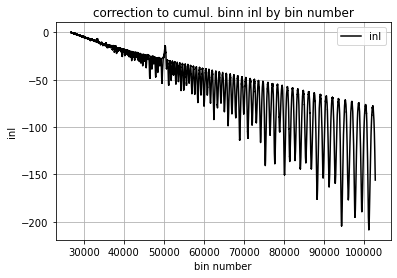

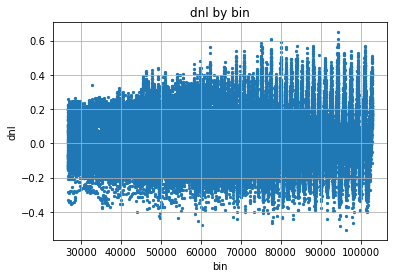

In [25]:
newedges = cumulativeedges(validcounts, filtbins, csnew, 1, 26759)
newinl = examineinl(newedges, "correction to cumul. binn", 26759)
newdnl = examinednl(newedges, 26759)

the computation time is 13.446531057357788
Binning beginning at 27000 has max and min inl vals 47.20120935286104 -0.12609063748823246
the computation time is 13.402078866958618
Binning beginning at 27001 has max and min inl vals 17.334293400490424 -0.23004801368369954
the computation time is 13.419822216033936
Binning beginning at 27002 has max and min inl vals 0.16768134789163014 -42.97928834510094
the computation time is 13.466206312179565
Binning beginning at 27003 has max and min inl vals 0.1693023027764866 -42.32442258868832


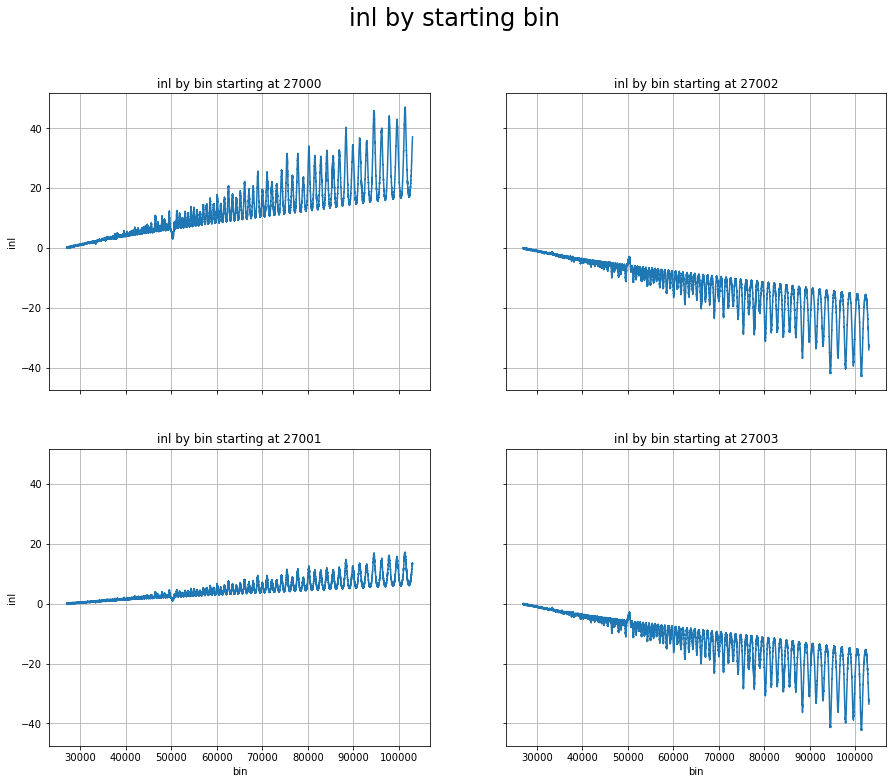

In [26]:
startingvals = np.arange(27000, 27004)
dnls = plotmanyinls(startingvals, validcounts ,filtbins, csnew)

the computation time is 13.19371509552002
Binning beginning at 27500 has max and min inl vals 20.417839866742725 -0.17731939103032346
the computation time is 13.233857154846191
Binning beginning at 27501 has max and min inl vals 12.188905186631018 -0.22854218975408003
the computation time is 13.321433067321777
Binning beginning at 27502 has max and min inl vals 0.1877698657590372 -13.649883141944883
the computation time is 13.207289934158325
Binning beginning at 27503 has max and min inl vals 0.172402771851921 -16.15058342163684


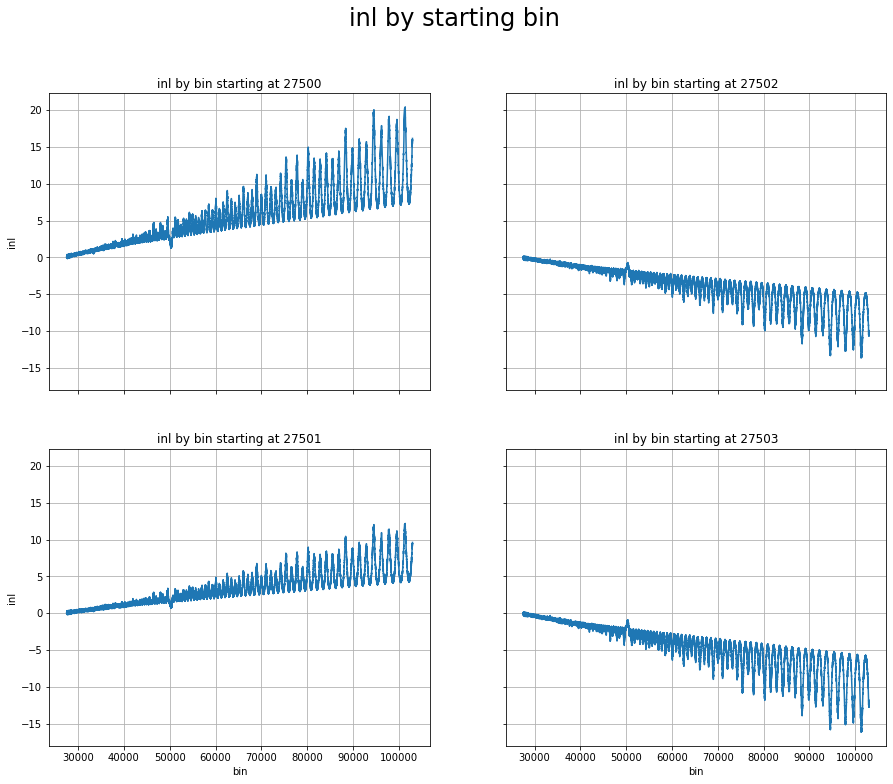

In [27]:
startingvals = np.arange(27500, 27504)
dnls = plotmanyinls(startingvals, validcounts ,filtbins, csnew)

the computation time is 13.161091089248657
Binning beginning at 28000 has max and min inl vals 16.738760558859212 -0.10012685589754255
the computation time is 13.240118026733398
Binning beginning at 28001 has max and min inl vals 6.410576312395278 -0.21303247893229127
the computation time is 13.230509042739868
Binning beginning at 28002 has max and min inl vals 0.1592989383643726 -13.754492176085478
the computation time is 13.115366220474243
Binning beginning at 28003 has max and min inl vals 0.1823371252467041 -11.157436026958749


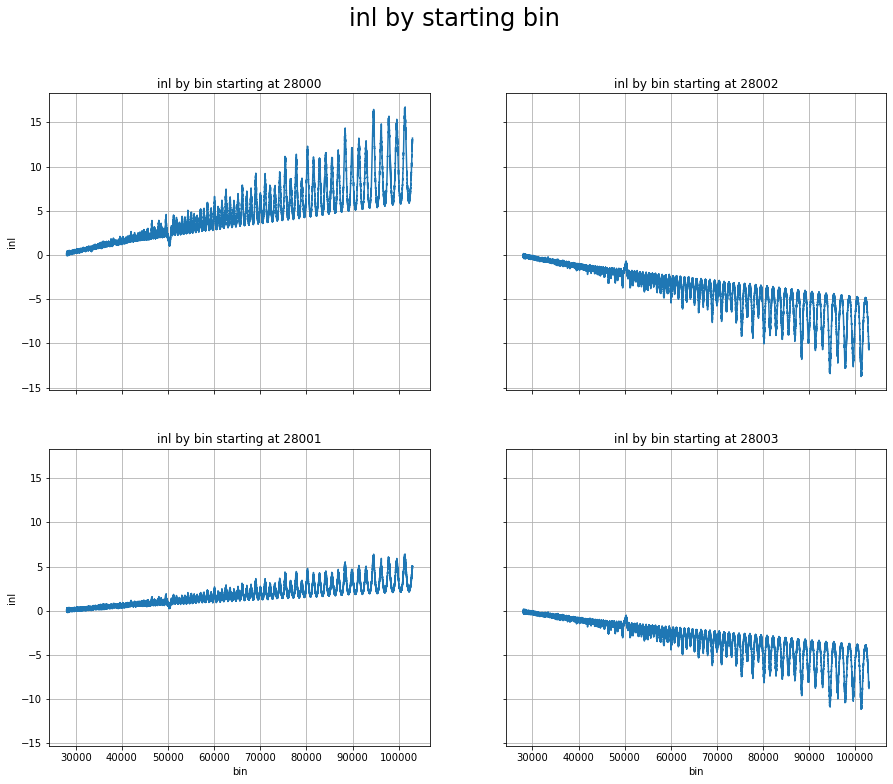

In [28]:
startingvals = np.arange(28000, 28004)
dnls = plotmanyinls(startingvals, validcounts ,filtbins, csnew)

the computation time is 13.00927209854126
Binning beginning at 28500 has max and min inl vals 0.25790720732766204 -2.1028142507420853
the computation time is 12.969736814498901
Binning beginning at 28501 has max and min inl vals 9.80888889306516 -0.1095869669043168
the computation time is 12.73062777519226
Binning beginning at 28502 has max and min inl vals 2.1400380930281244 -0.21822062835417455
the computation time is 12.824467897415161
Binning beginning at 28503 has max and min inl vals 0.21692248060571728 -4.991346536116907


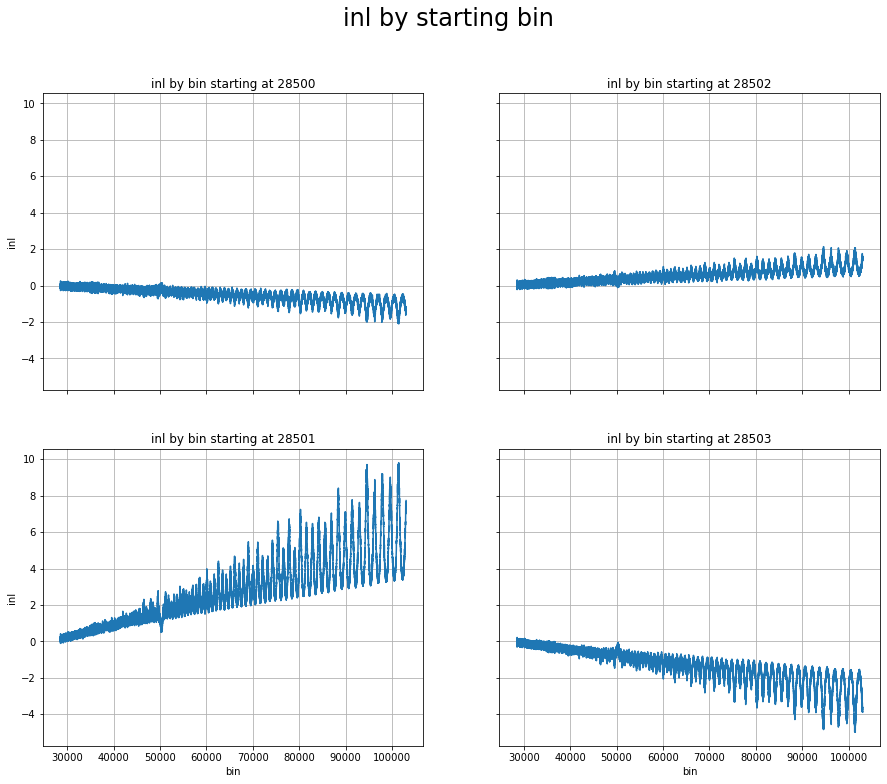

In [29]:
startingvals = np.arange(28500, 28504)
dnls = plotmanyinls(startingvals, validcounts ,filtbins, csnew)

the computation time is 12.683225870132446
Binning beginning at 29000 has max and min inl vals 0.09066873379197204 -8.89351440370956
the computation time is 12.806678056716919
Binning beginning at 29001 has max and min inl vals 0.14524483891727868 -5.995563695483725
the computation time is 12.601155996322632
Binning beginning at 29002 has max and min inl vals 6.86357037864218 -0.13496508153912146
the computation time is 12.711774110794067
Binning beginning at 29003 has max and min inl vals 4.828999697987456 -0.16910902105882997


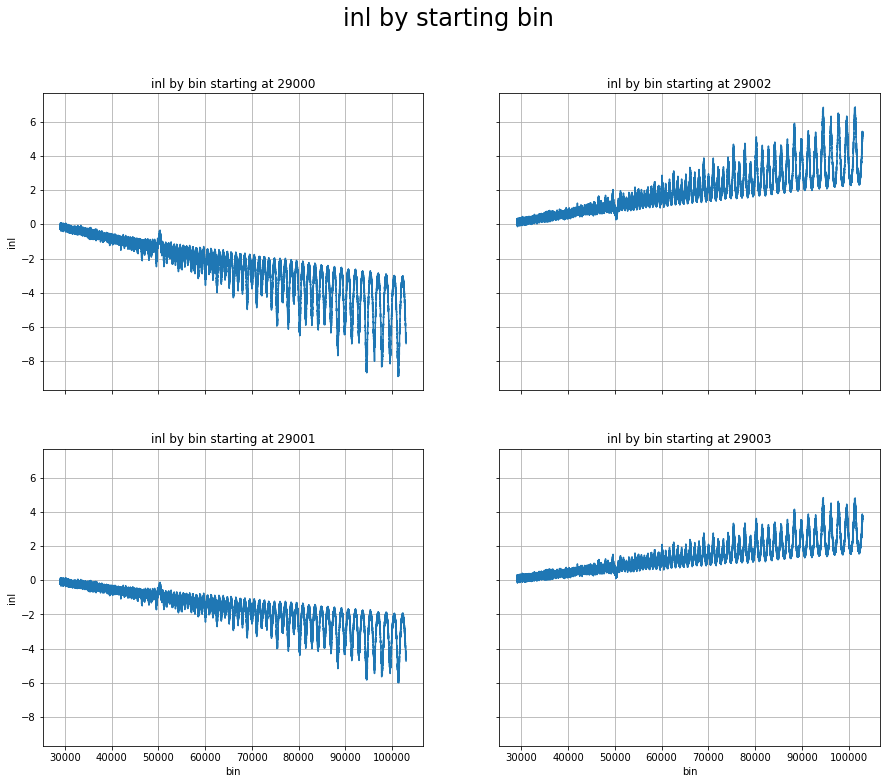

In [30]:
startingvals = np.arange(29000, 29004)
dnls = plotmanyinls(startingvals, validcounts ,filtbins, csnew)

the computation time is 12.532878875732422
Binning beginning at 29500 has max and min inl vals 0.17540164443926187 -4.808559076715028
the computation time is 12.692748069763184
Binning beginning at 29501 has max and min inl vals 0.22583165518153692 -2.8152340229280526
the computation time is 12.566479921340942
Binning beginning at 29502 has max and min inl vals 6.360868743766332 -0.10678781855676789
the computation time is 12.634403228759766
Binning beginning at 29503 has max and min inl vals 2.7262142741237767 -0.18494604569787043


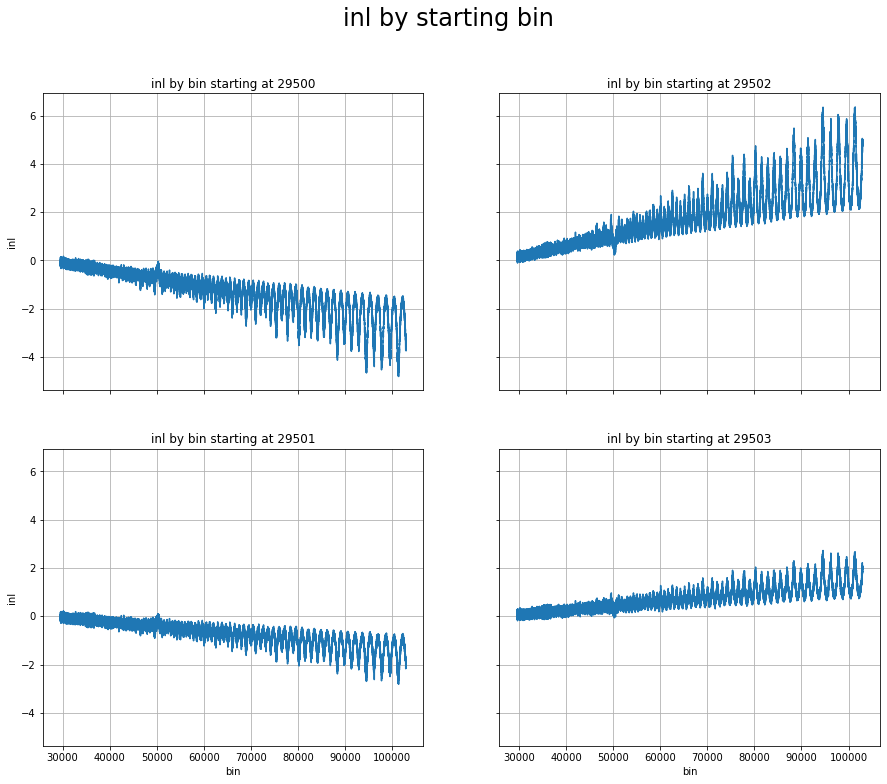

In [31]:
startingvals = np.arange(29500, 29504)
dnls = plotmanyinls(startingvals, validcounts ,filtbins, csnew)

the computation time is 12.441694974899292
Binning beginning at 30000 has max and min inl vals 0.1914610974417883 -4.175612220133189
the computation time is 12.440827131271362
Binning beginning at 30001 has max and min inl vals 0.21694923541508615 -3.169427715765778
the computation time is 12.454932928085327
Binning beginning at 30002 has max and min inl vals 4.990199791966006 -0.11386132701591123
the computation time is 12.518371105194092
Binning beginning at 30003 has max and min inl vals 2.9325532083021244 -0.1684889795287745


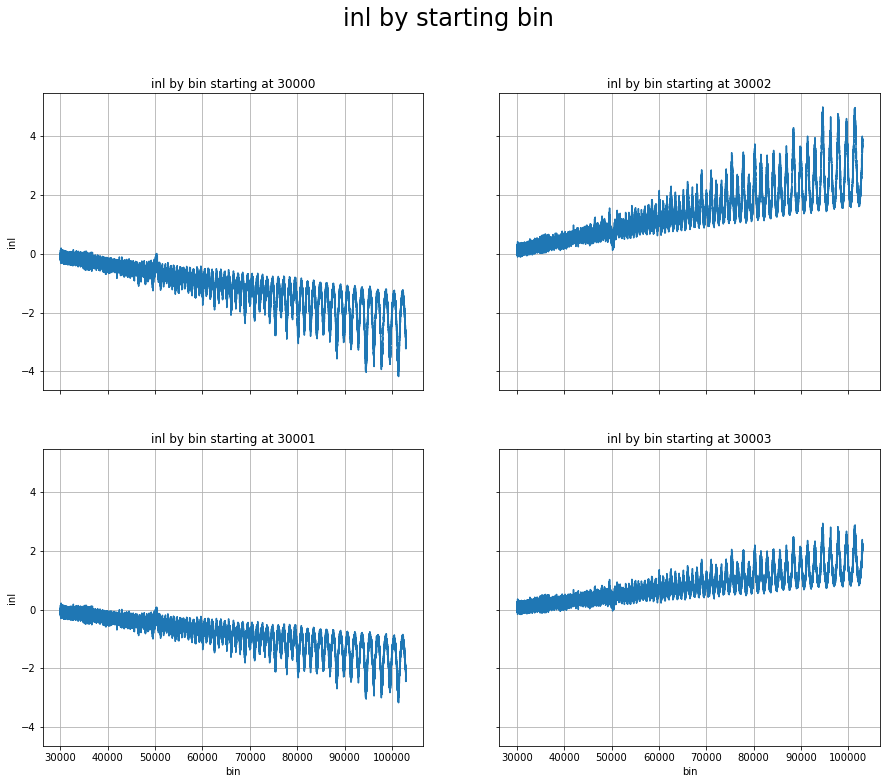

In [32]:
startingvals = np.arange(30000, 30004)
dnls = plotmanyinls(startingvals, validcounts ,filtbins, csnew)

## You still will need to do something or figure out why this changes so much

## 3. Examine the dnl of other adcs (by amp)

In [33]:
amplist = ["C00", "C01", "C02", "C03", "C04", "C05", "C06", "C07", "C10", "C11", 
           "C12", "C13", "C14", "C15", "C16", "C17"]

def plotdnls(amplist, start): 
    fig = plt.figure(figsize=(20,18))
    axes = fig.subplots(8,2, sharex=True, sharey=True)
    fig.suptitle('run 13144 dnl vs bin by amp', fontsize=24)
    plt.setp(axes[7,0], xlabel = 'bin', ylabel = 'count') #fix the labels so on all of them 
    plt.setp(axes[7,1], xlabel = 'bin')
    a = 0
    b = 0 
    c = 0 
    while c < 7: 
        plt.setp(axes[c,0], ylabel = 'count')
        c += 1 
    for amp in amplist: 
        counts, bins = load_dataset(amp) #but use the method of throwing out bins that are negative
        cs, ncounts, fbins, filtered = filter_dataset_adjust_new(counts, bins)
        if start == 0: 
            st = fbins[0]
        else: 
            st = start
        edges = cumulativeedges(ncounts, fbins, cs, 1, st) 
        dnl = getdnl(edges, st)
        axes[a,b].scatter(np.arange(st, st+len(dnl)), dnl, s=0.2)
        axes[a,b].set_title(f"{amp}")
        axes[a,b].grid()
        if a < 7: 
            a +=1 
        else: 
            b +=1 
            a = 0

the computation time is 12.288150072097778
the computation time is 12.374534130096436
the computation time is 12.309590816497803
the computation time is 12.183213233947754
the computation time is 12.299598217010498
the computation time is 12.32014012336731
the computation time is 12.21324896812439
the computation time is 12.269291162490845
the computation time is 12.371255874633789
the computation time is 12.293260097503662
the computation time is 12.254808187484741
the computation time is 12.254333257675171
the computation time is 12.308078050613403
the computation time is 12.349679708480835
the computation time is 12.237046957015991
the computation time is 12.154160976409912


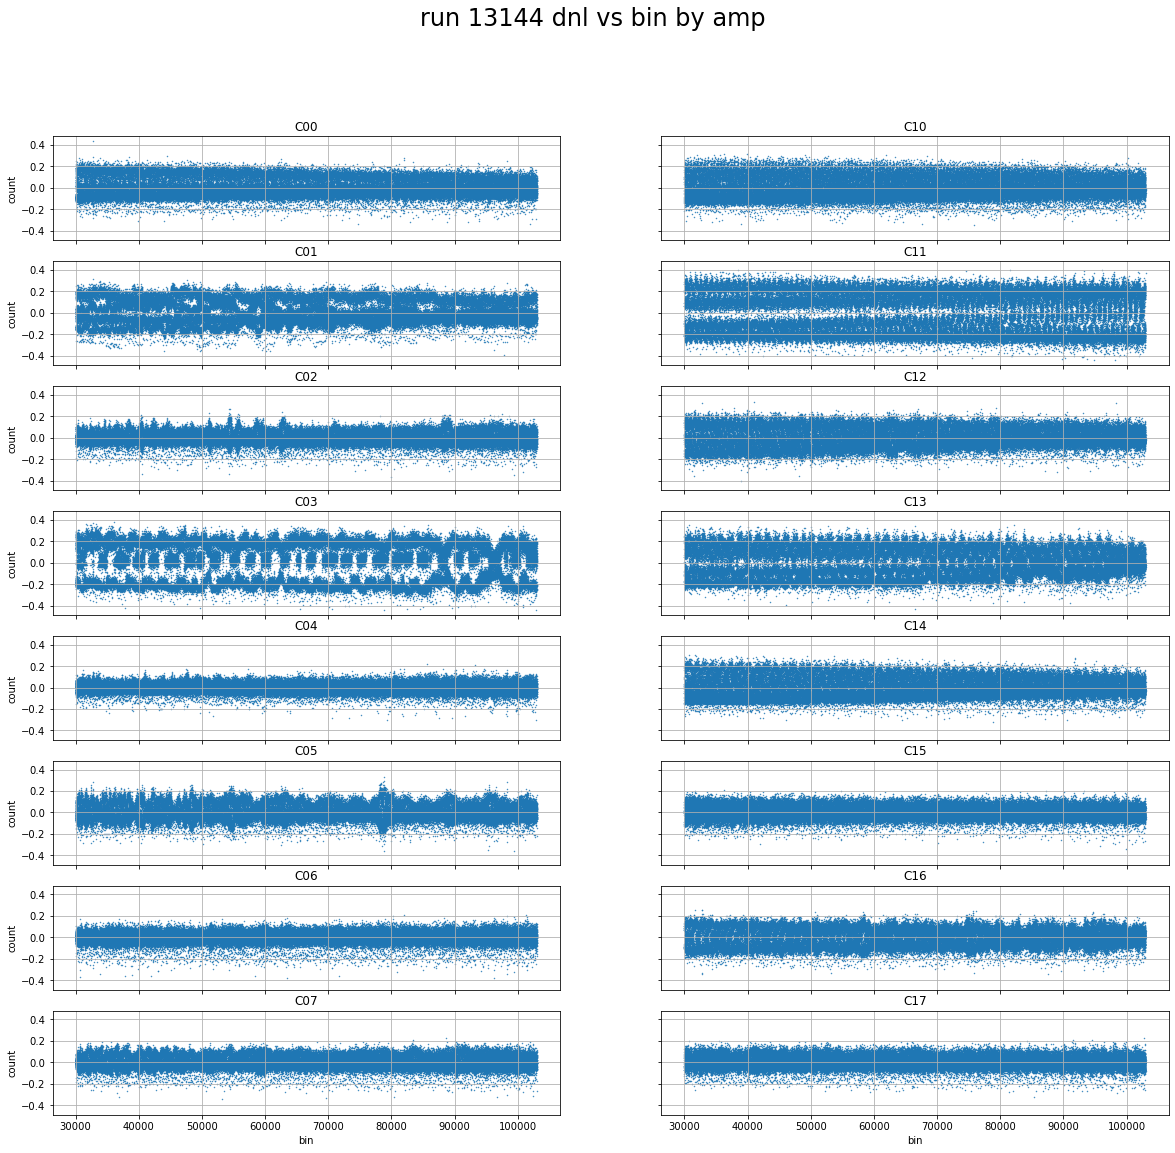

In [34]:
plotdnls(amplist, 30000)

the computation time is 13.455641031265259
the computation time is 13.62517237663269
the computation time is 13.520401239395142
the computation time is 13.400329113006592
the computation time is 13.49020528793335
the computation time is 13.4616219997406
the computation time is 13.351599216461182
the computation time is 13.455163955688477
the computation time is 13.479233026504517
the computation time is 13.310180187225342
the computation time is 13.384044885635376
the computation time is 13.388027906417847
the computation time is 13.3972647190094
the computation time is 13.382632970809937
the computation time is 13.458460807800293
the computation time is 13.403984785079956


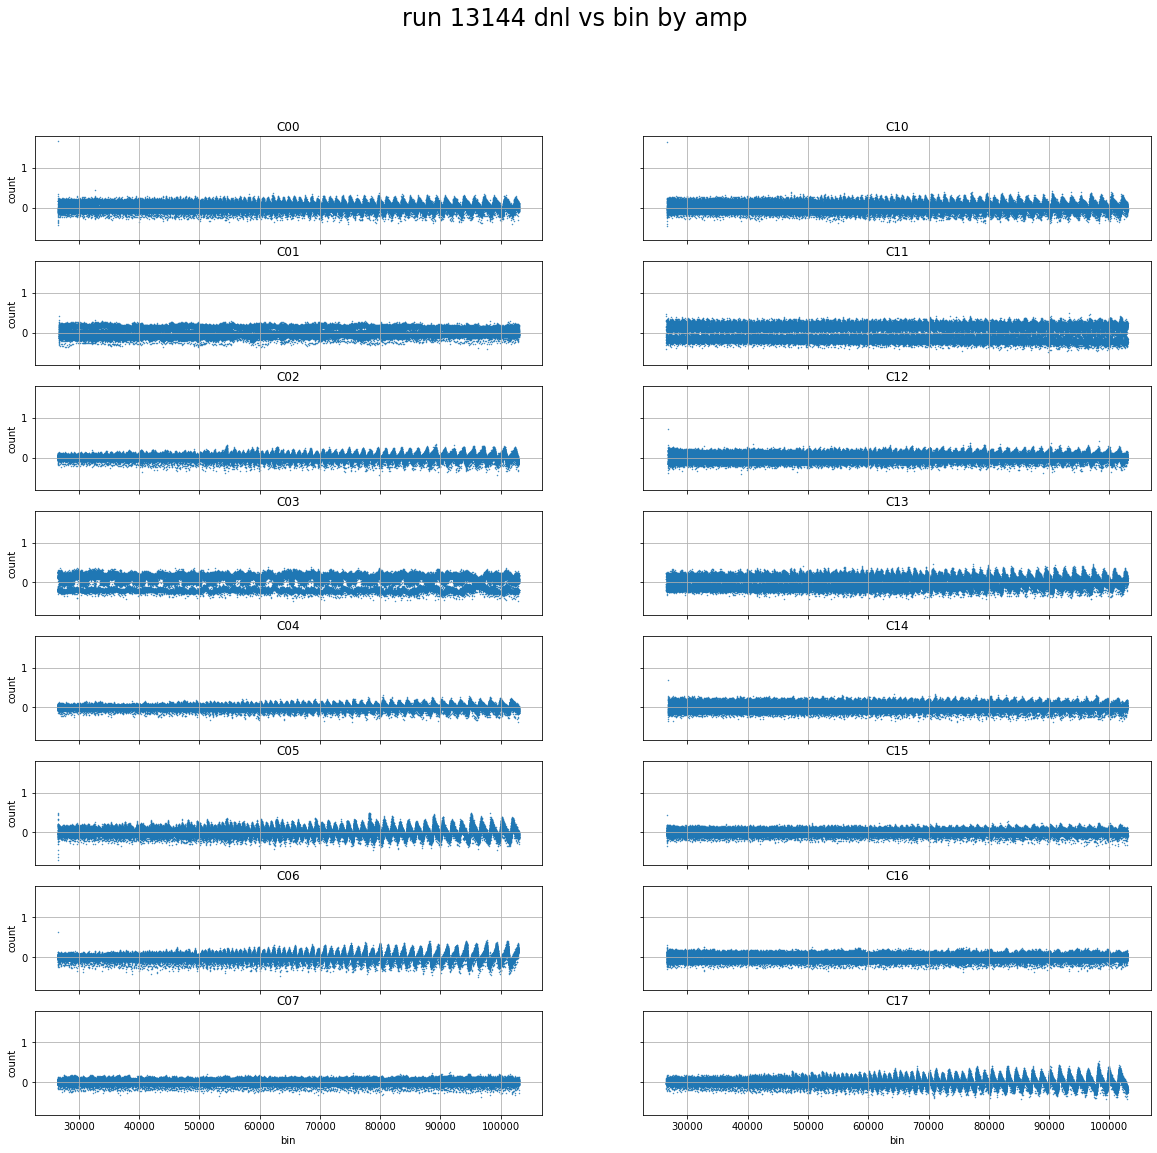

In [35]:
#starting at the earliest possible bin
plotdnls(amplist, 0)

## 4. Examine the dataset; the downticks
From the plot below you can see downticks in the superhist, determine if they are evenly spaced and how the filter responds in that region.
This is for the NEW method of the filtering. 

In [36]:
counts, bins = load_dataset("C01")
csnew, validcounts, filtbins, filtered = filter_dataset_adjust_new(counts, bins)

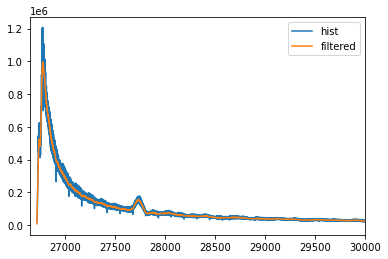

In [37]:
plt.plot(filtbins, validcounts, label='hist')
plt.plot(filtbins, filtered, label='filtered')
plt.xlim(26650, 30000) #starts at 26707 
plt.legend()

In [38]:
def zoomplot(start, stop, ylim):
    plt.plot(filtbins, validcounts, label='hist')
    plt.plot(filtbins, filtered, label='filtered')
    plt.title(f"hist and filter from bin {start} to {stop}")
    plt.ylabel("count")
    plt.xlabel("bin")
    plt.xlim(start, stop) #starts at 26707 
    plt.ylim(0, ylim)
    plt.legend()
    plt.show()

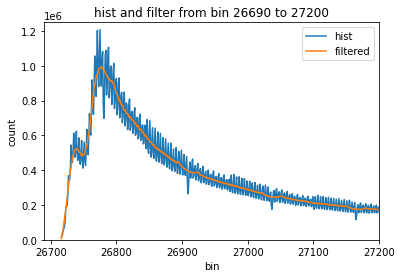

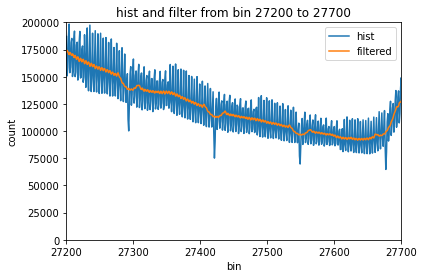

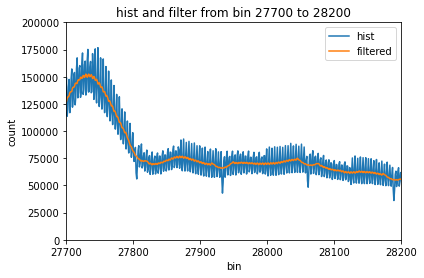

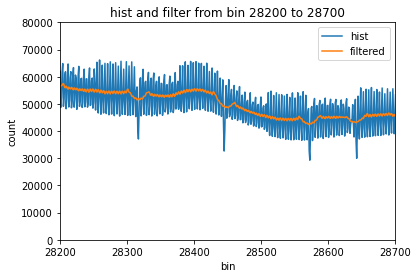

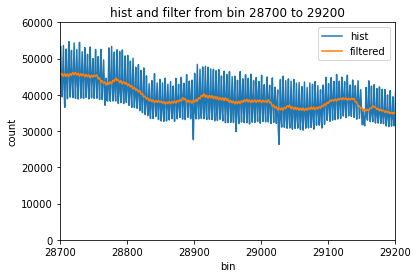

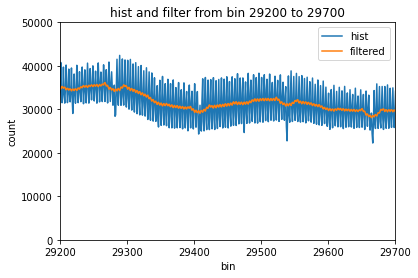

In [39]:
zoomplot(26690, 27200, 1.25e6)
zoomplot(27200, 27700, 2e5)
zoomplot(27700, 28200, 2e5)
zoomplot(28200, 28700, 8e4)
zoomplot(28700, 29200, 6e4)
zoomplot(29200, 29700, 5e4)

from the zoom plots above, we see that the savgol filter does in fact follow these artifact downticks throughout the region start-30k. It would be helpful to know how they are spaced, it is suggested that they should be are every 128 counts or another power of 2 (as a characteristic of the adc). 

In [40]:
mins= scipy.signal.find_peaks(-validcounts, distance=70, prominence=[1e4, None], width=2)
boi = filtbins[mins[0]]

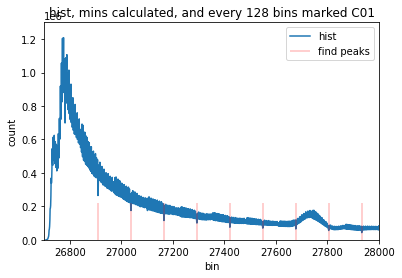

In [41]:
plt.plot(bins, counts, label='hist')
plt.eventplot(boi, color='red', linelengths=4e5, lineoffsets = 2e4, label='find peaks', alpha=0.25)
plt.xlim(26700, 28000) 
plt.ylabel("count")
plt.xlabel("bin")
plt.title("hist, mins calculated, and every 128 bins marked C01")
plt.ylim(0, 1.3e6)
plt.legend()

Try with C00 amplifier as well

In [42]:
counts, bins = load_dataset("C00")
csnew, validcounts, filtbins, filtered = filter_dataset_adjust_new(counts, bins)

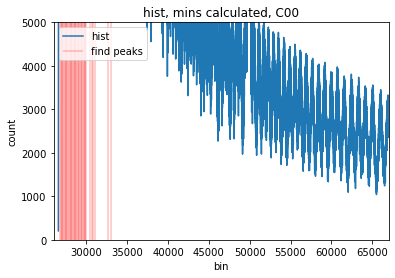

In [43]:
mins= scipy.signal.find_peaks(-validcounts, distance=70, prominence=[1e4, None], width=2)
boi = filtbins[mins[0]]

plt.plot(bins, counts, label='hist')
plt.eventplot(boi, color='red', linelengths=4e6, lineoffsets = 2.5e4, label='find peaks', alpha=0.25)

#plt.xlim(26600, 28000) #starts at 26707 
plt.ylabel("count")
plt.xlabel("bin")
plt.title("hist, mins calculated, C00")
#plt.ylim(0, 1.3e6)
plt.xlim(26000, 67000) #starts at 26707 
plt.ylim(0, 5e3)
plt.legend()

## 5. refine a method to be able to see separations between the mins determined, and plot the early region of each amp with ticks (mins) labeled

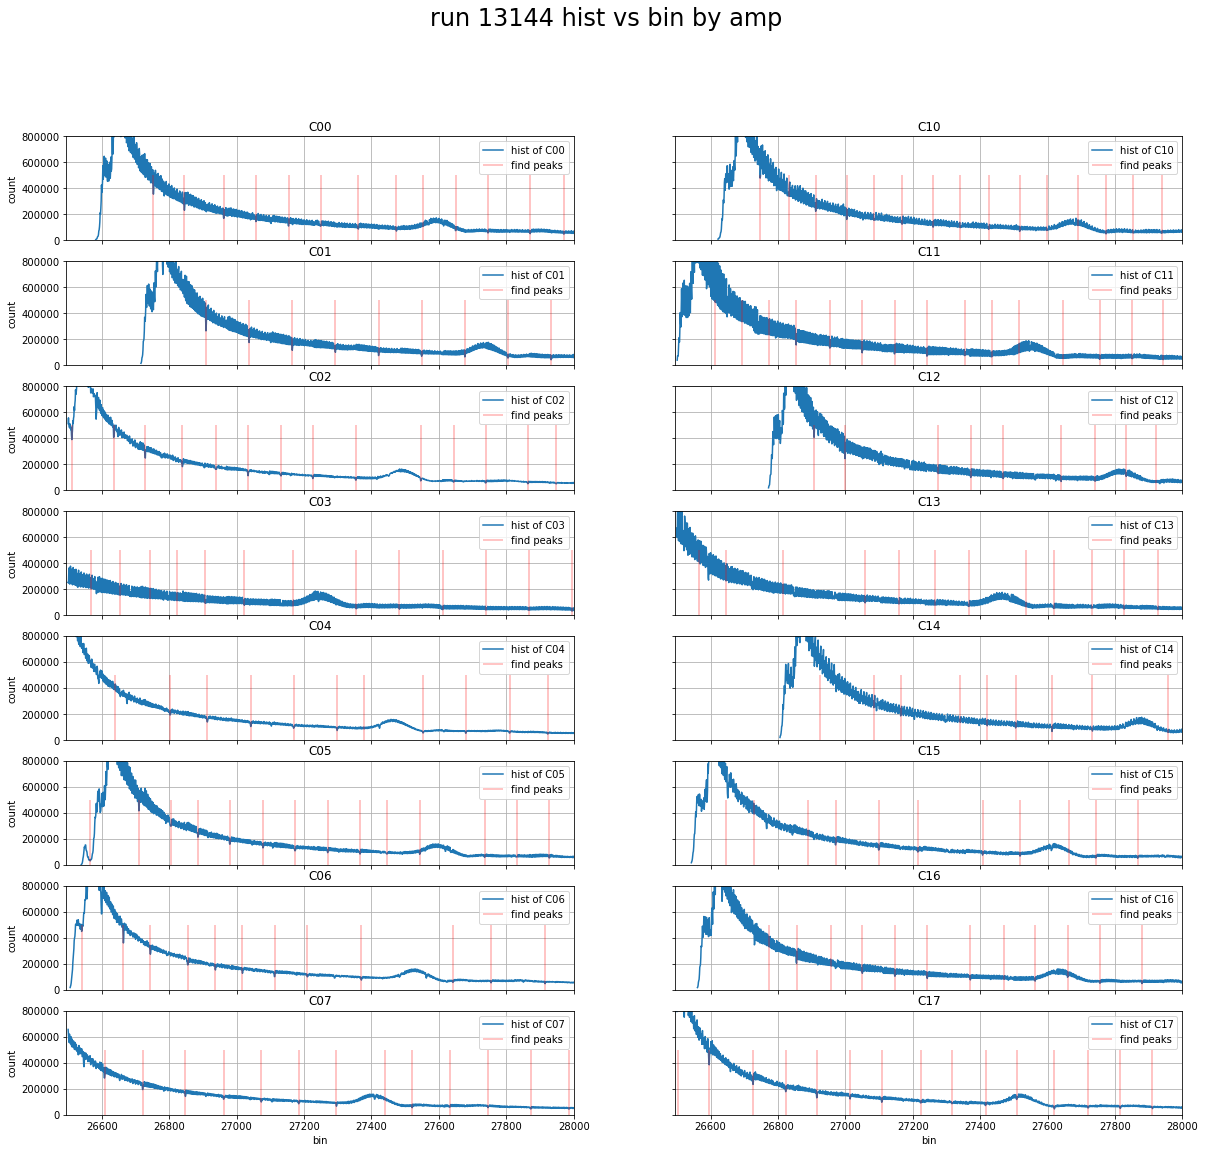

In [44]:
amplist = ["C00", "C01", "C02", "C03", "C04", "C05", "C06", "C07", "C10", "C11", 
           "C12", "C13", "C14", "C15", "C16", "C17"]
ampsep = {}
fig = plt.figure(figsize=(20,18))
axes = fig.subplots(8,2, sharex=True, sharey=True)
fig.suptitle('run 13144 hist vs bin by amp', fontsize=24)
plt.setp(axes[7,0], xlabel = 'bin', ylabel = 'count') #fix the labels so on all of them 
plt.setp(axes[7,1], xlabel = 'bin')
a = 0
b = 0 
c = 0 
while c < 7: 
    plt.setp(axes[c,0], ylabel = 'count')
    c += 1 

for amp in amplist: 
    counts, bins = load_dataset(amp)
    csnew, validcounts, filtbins, filtered = filter_dataset_adjust_new(counts, bins)
    mins= scipy.signal.find_peaks(-validcounts, distance=80, prominence=[1e4, None], width=2)
    #mins = scipy.signal.find_peaks(-validcounts, distance=32, prominence=[1e3, None], width=2)
    boi = filtbins[mins[0]]
    
    separations = []
    for x in range(len(boi)-1):
        diff = boi[x+1] - boi[x]
        separations.append(diff)
    mode = statistics.mode(separations)
    ampsep[amp] = [separations, mode]
    
    axes[a,b].plot(filtbins, validcounts, label=f"hist of {amp}")
    axes[a,b].eventplot(boi, color='red', linelengths=5e5, lineoffsets=2.5e5, alpha=0.3, label='find peaks')
    axes[a,b].set_title(f"{amp}")
    axes[a,b].grid()
    axes[a,b].set_xlim(26495, 28000)
    axes[a,b].set_ylim(0, 8e5)
    axes[a,b].legend()
    if a < 7: 
        a +=1 
    else: 
        b +=1 
        a = 0

make a table of the values you just computed, then make a histogram of them

In [45]:
from tabulate import tabulate

head = ["amp", "first 10 separations", "mode separation"]
table=[]
for amp in ampsep.keys():
    linetable = [amp, ampsep[amp][0][:10], ampsep[amp][1]]
    table.append(linetable)

print(tabulate(table, headers=head))

amp    first 10 separations                                  mode separation
-----  --------------------------------------------------  -----------------
C00    [92, 117, 95, 97, 95, 112, 113, 80, 96, 96]                        96
C01    [128, 128, 128, 128, 128, 128, 128, 128, 128, 128]                128
C02    [124, 94, 110, 99, 96, 98, 94, 128, 192, 98]                       94
C03    [86, 88, 80, 84, 116, 144, 188, 128, 128, 128]                    128
C04    [164, 110, 129, 127, 129, 81, 174, 127, 130, 113]                 128
C05    [144, 95, 80, 95, 98, 95, 97, 96, 80, 97]                          96
C06    [124, 80, 111, 82, 80, 96, 97, 160, 272, 113]                      80
C07    [113, 127, 113, 112, 111, 112, 145, 80, 111, 114]                 113
C10    [85, 80, 92, 80, 84, 92, 81, 84, 92, 80]                           80
C11    [80, 80, 81, 100, 96, 96, 96, 112, 80, 80]                         96
C12    [92, 276, 97, 96, 172, 101, 92, 88, 88, 96]                        92

seems that the downticks are more pronounced in some amps than others. Adjusting the specificaitons for the downticks is possible, but it seems dififcult to suggest that doing all 16 amps together is sufficient (at this time). 


It also is apparent that the bias level is below the cutoff used in this method for some of the amps: can split them into two groups sufficient and not, where sufficient shows where the signal is zero and then increases, and not sufficient misses this region 


the 26500 cutoff sufficient: C00, C01, C05, C06, C10, C11, C12, C14, C15, C16. the 26500 cutoff not sufficient: C02, C03, C04, C07, C13, C17. 

## 6. Plot without the downticks and see if visibly noticable and fine tune which amps most pronounced (?) 

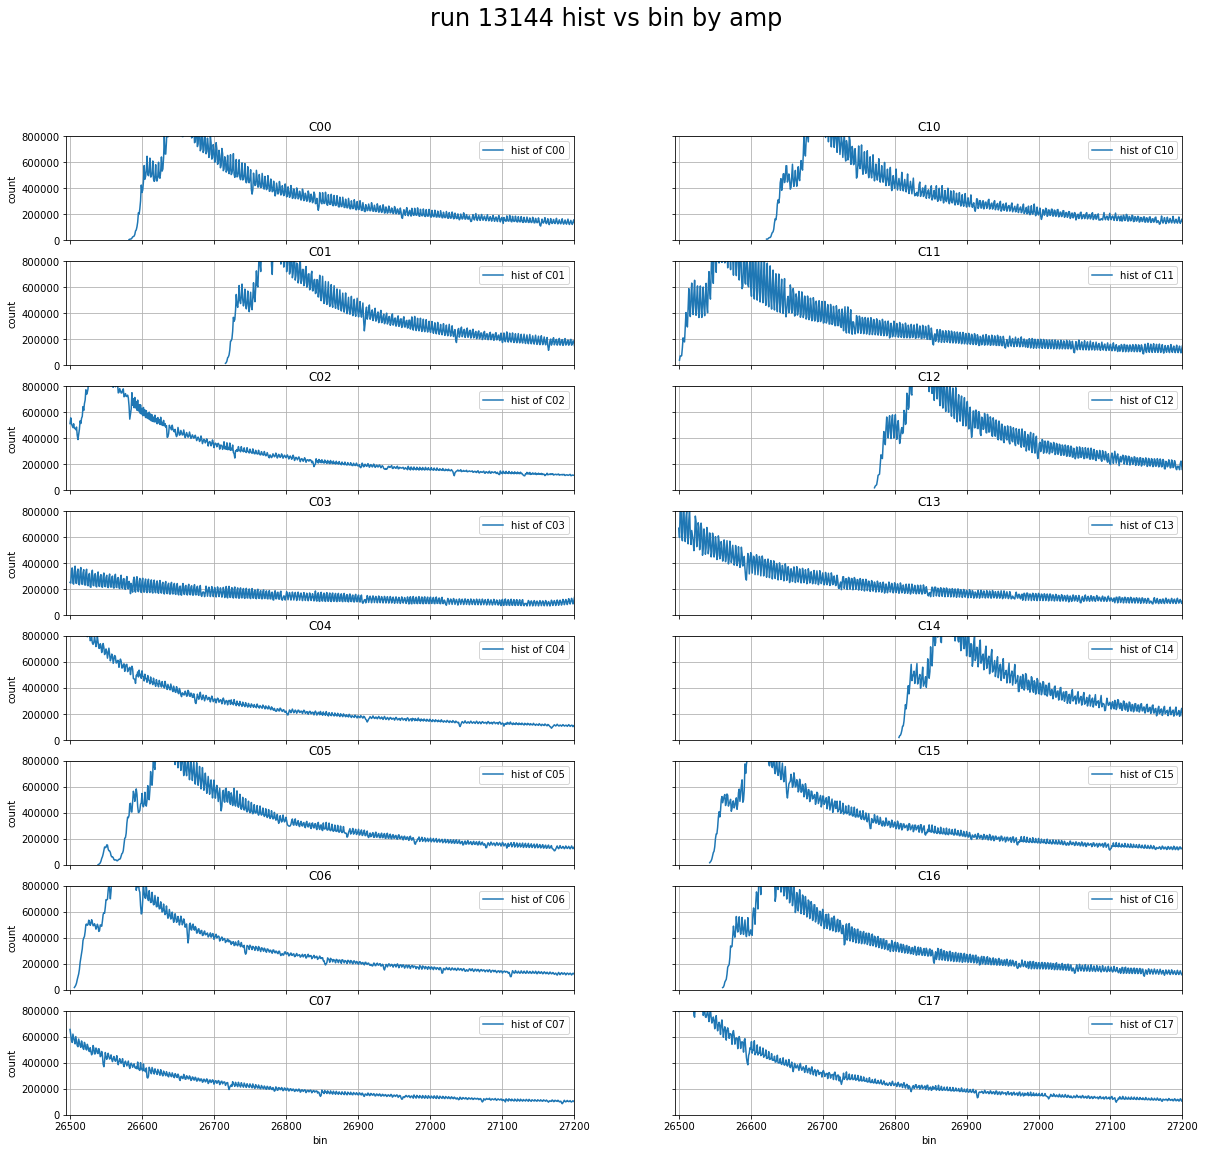

In [46]:
fig = plt.figure(figsize=(20,18))
axes = fig.subplots(8,2, sharex=True, sharey=True)
fig.suptitle('run 13144 hist vs bin by amp', fontsize=24)
plt.setp(axes[7,0], xlabel = 'bin', ylabel = 'count') #fix the labels so on all of them 
plt.setp(axes[7,1], xlabel = 'bin')
a = 0
b = 0 
c = 0 
while c < 7: 
    plt.setp(axes[c,0], ylabel = 'count')
    c += 1 
for amp in amplist: 
    counts, bins = load_dataset(amp)
    csnew, validcounts, filtbins, filtered = filter_dataset_adjust_new(counts, bins)

    axes[a,b].plot(filtbins, validcounts, label=f"hist of {amp}")
    axes[a,b].set_title(f"{amp}")
    axes[a,b].grid()
    axes[a,b].set_xlim(26495, 27200)
    axes[a,b].set_ylim(0, 8e5)
    axes[a,b].legend()
    if a < 7: 
        a +=1 
    else: 
        b +=1 
        a = 0

## 7. Plot the residual-count for the entire range using the method specified here 

ie how much the residal is for each bin 

In [47]:
def cumulativeedgesresiduals(counts, bins, spline, un, start):
    st = time.time() #time the algorithm ? 
    checkstartingbin(start, bins)
    edges = [start] #edges start at leftmost bin
    residualcumsum = spline(start) #the cumsum of the bins not included in the binning 
    firstcount = np.argwhere(bins == start) #start using values where specified     
    rightgoals = np.cumsum(counts[firstcount[0][0]:]) #the cumsum of the counts to be achieved; ie the right edge
    goals = rightgoals + residualcumsum #add in the ped of the spline discarded 
    
    residuals = []
    for a in range(len(goals)): 
        left = edges[-1]
        if left > 102999.5: #prevent interpolation beyond what we have for bins
            break
        right = left + 1 #standard bin width = 1
        cv = spline(right) #current value, based on current right edge
        bcvar = 0.25 #bin change variable (start with 25% change)  
        x =0
        while len(edges) != a+2: 
            if goals[a]-un < cv < goals[a] + un: #specify the requirement
                edges.append(right)
                resid = goals[a] - cv
                residuals.append(resid)
            elif cv < goals[a]: #bin is too small, widen right edge
                right, bcvar = makewide(bcvar, right, left)
                cv = spline(right)
                if x >1500:
                    print("help small", a)
            elif cv > goals[a]:  #bin is too big, reduce right edge
                right, bcvar = makenarrow(bcvar, right, left)
                cv = spline(right)
                if x >1500:
                    print("help big", a)
            x+= 1
    end = time.time()
    print("the computation time is", end-st)
    return edges, residuals

In [48]:
counts, bins = load_dataset("C01")
csnew, validcounts, filtbins, filtered = filter_dataset_adjust_new(counts, bins)
newedges, residuals = cumulativeedgesresiduals(validcounts, filtbins, csnew, 1, 30000)

the computation time is 11.827367305755615


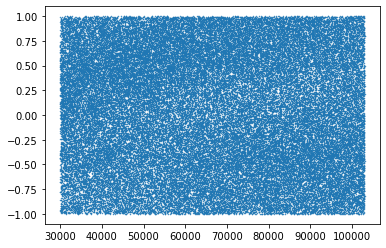

In [49]:
plt.scatter(np.arange(30000, 30000+len(residuals)), residuals, s=0.2)
#plt.xlim(30000, 35000)

(array([6474., 6944., 7474., 7230., 6856., 6708., 7191., 7977., 8251.,
        7892.]),
 array([-9.99979615e-01, -7.99987233e-01, -5.99994850e-01, -4.00002468e-01,
        -2.00010085e-01, -1.77025795e-05,  1.99974680e-01,  3.99967062e-01,
         5.99959445e-01,  7.99951828e-01,  9.99944210e-01]),
 <BarContainer object of 10 artists>)

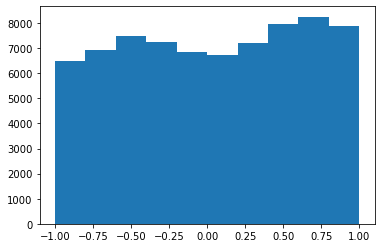

In [50]:
plt.hist(residuals)

In [51]:
print(sum(residuals))
print("the residual is count from hist - value of the count")

2435.1632155776024
the residual is count from hist - value of the count


In [52]:
#try different convergence intervals 
newedges, residuals = cumulativeedgesresiduals(validcounts, filtbins, csnew, 10, 30000)
print(sum(residuals))

the computation time is 7.010387897491455
71949.55638039112


In [53]:
newedges, residuals = cumulativeedgesresiduals(validcounts, filtbins, csnew, 0.1, 30000)
print(sum(residuals))

the computation time is 17.622334241867065
403.70957112312317


In [54]:
newedges, residuals = cumulativeedgesresiduals(validcounts, filtbins, csnew, 0.01, 30000)
print(sum(residuals))

the computation time is 24.255277156829834
16.36022537946701


so this tells me that the method on average takes bins to be too small (on average), since we get a positive residual. The residual as defined is count - value in the method, so for this to be positive on average, the count needs to be larger than the bin values. It trends towards zero as the precision increases tho. It would be interesting to see across many amps, so I will do this next. 

==> could also plot the value from the method vs the count to see if there is some correlation but this may get very busy so I will hold off

Plot the inl for each of the amps, then export the residuals and plot those too 

the computation time is 17.56546401977539
the computation time is 17.51713490486145
the computation time is 17.252886056900024
the computation time is 17.188156843185425
the computation time is 17.395031929016113
the computation time is 18.100897789001465
the computation time is 17.60082197189331
the computation time is 17.38598608970642
the computation time is 17.233005046844482
the computation time is 17.44334077835083
the computation time is 17.345212936401367
the computation time is 17.279439210891724
the computation time is 17.31519103050232
the computation time is 17.424371004104614
the computation time is 17.309532165527344
the computation time is 17.440130949020386


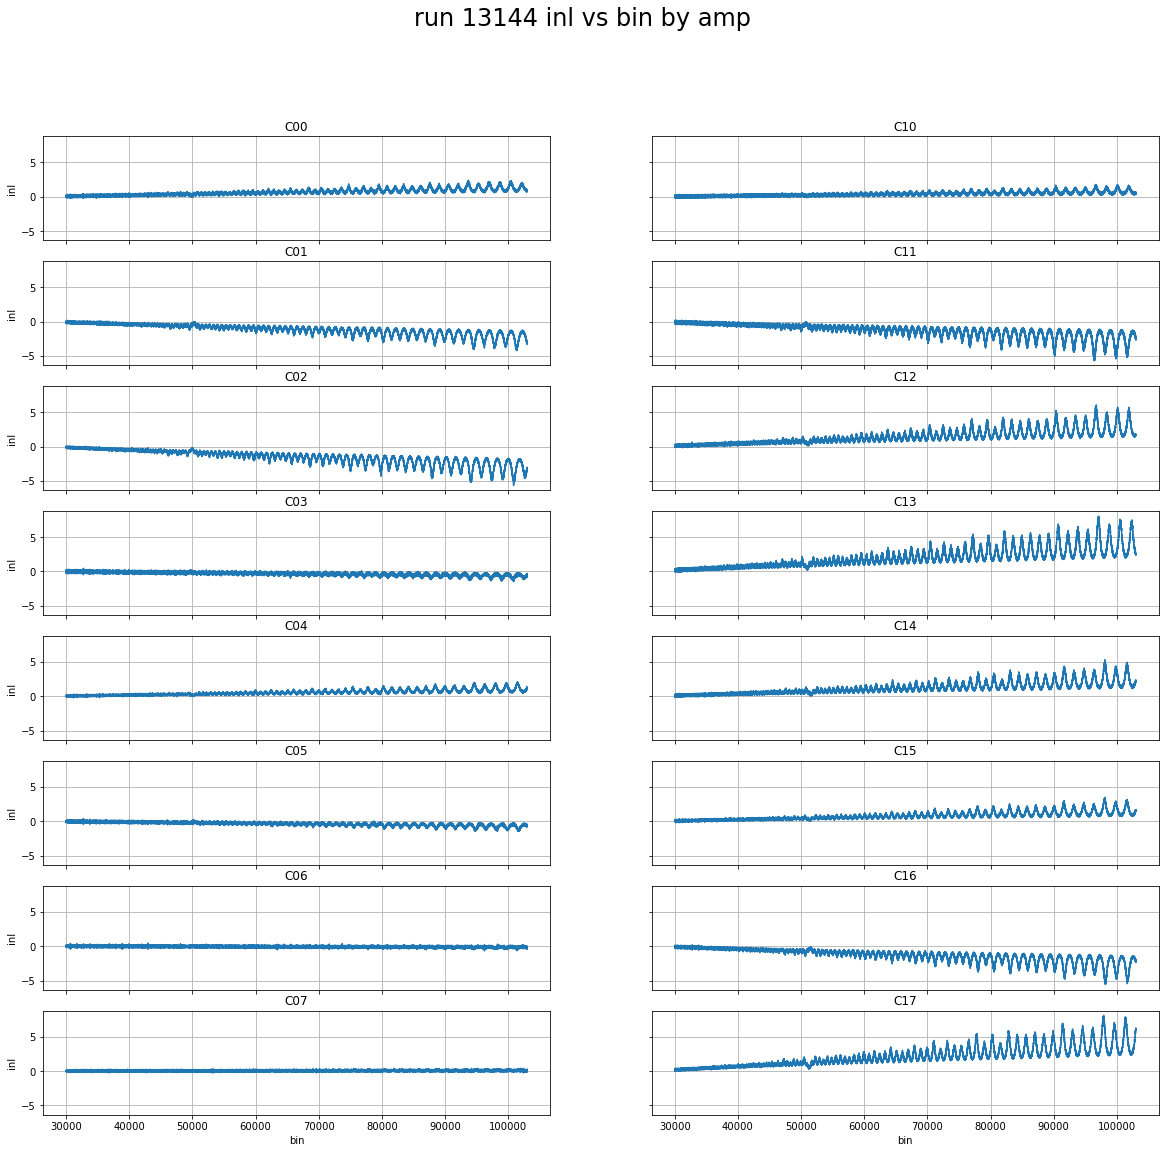

In [55]:
resids = {} #dictionary of the residuals so you can plot them after you plot the inl 
inls = {} #dictionary save the inl
fig = plt.figure(figsize=(20,18))
axes = fig.subplots(8,2, sharex=True, sharey=True)
fig.suptitle('run 13144 inl vs bin by amp', fontsize=24)
plt.setp(axes[7,0], xlabel = 'bin', ylabel = 'inl') #fix the labels so on all of them 
plt.setp(axes[7,1], xlabel = 'bin')
a = 0
b = 0 
c = 0 
while c < 7: 
    plt.setp(axes[c,0], ylabel = 'inl')
    c += 1 
for amp in amplist: 
    counts, bins = load_dataset(amp)
    csnew, validcounts, filtbins, filtered = filter_dataset_adjust_new(counts, bins)
    #make the edges and residuals
    edges, residuals = cumulativeedgesresiduals(validcounts, filtbins, csnew, 0.1, 30000)
    #get the inl 
    inl = getinl(edges, 30000)
    resids[amp] = residuals 
    inls[amp] = inl 
    ### plot the inl 
    axes[a,b].plot(np.arange(30000, 30000+len(inl)), inl)
    axes[a,b].set_title(f"{amp}")
    axes[a,b].grid()
    if a < 7: 
        a +=1 
    else: 
        b +=1 
        a = 0

the computation time is 11.780503988265991


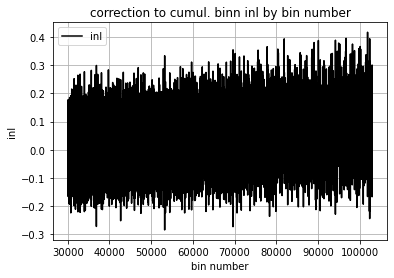

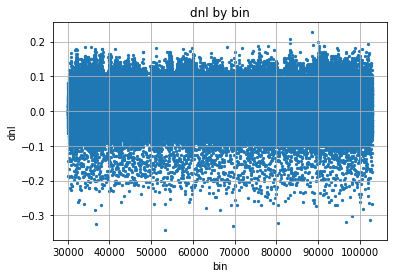

In [56]:
counts, bins = load_dataset("C07")
csnew, validcounts, filtbins, filtered = filter_dataset_adjust_new(counts, bins)
newedges = cumulativeedges(validcounts, filtbins, csnew, 1, 30000)
newinl = examineinl(newedges, "correction to cumul. binn", 30000)
newdnl = examinednl(newedges, 30000)

In [57]:
for amp in resids.keys(): 
    print(amp, sum(resids[amp]))

C00 395.99426847696304
C01 403.70957112312317
C02 431.8896297812462
C03 409.71370446681976
C04 423.37407499551773
C05 432.7070582509041
C06 415.47068548202515
C07 448.90107184648514
C10 397.16783607006073
C11 384.08397525548935
C12 422.9984166622162
C13 419.56742841005325
C14 402.2863087654114
C15 413.3142203092575
C16 382.21676433086395
C17 402.9580381512642


the above tells me that the method works well for all the amplifiers in the dataset, but it does on average make bins that are narrower than expected. This is an interesting result coupled with the inl being both + and - depending on the amplifier. So I think there may be more to the story. 

I am curious if somehow the first bin dictates the behavior of the entire inl. My thought is something like the first "error" propogates through the entire code. So I will look at the final inl (to get the sign of the trending inl) and the first residual, and compare their signs to see if I get more information. 

In [58]:
head = ["amp", "first residual", "final inl"]
table=[]
for amp in resids.keys():
    linetable = [amp, resids[amp][0], inls[amp][-1]]
    table.append(linetable)

print(tabulate(table, headers=head))

amp      first residual    final inl
-----  ----------------  -----------
C00          0.0712844     0.828989
C01         -0.0946059    -3.20398
C02         -0.0548646    -3.071
C03         -0.0918616    -0.50972
C04          0.0504614     1.221
C05         -0.00122327   -0.546236
C06         -0.00929743   -0.191835
C07         -0.0123025     0.0319778
C10          0.0225095     0.516796
C11          0.0495875    -2.67033
C12          0.0105123     1.76606
C13          0.0451097     2.4274
C14         -0.0698825     2.3102
C15          0.0758266     1.62565
C16         -0.0334024    -2.31237
C17         -0.02217       6.11715


C07, C11, C14, C17 have differing signs. 

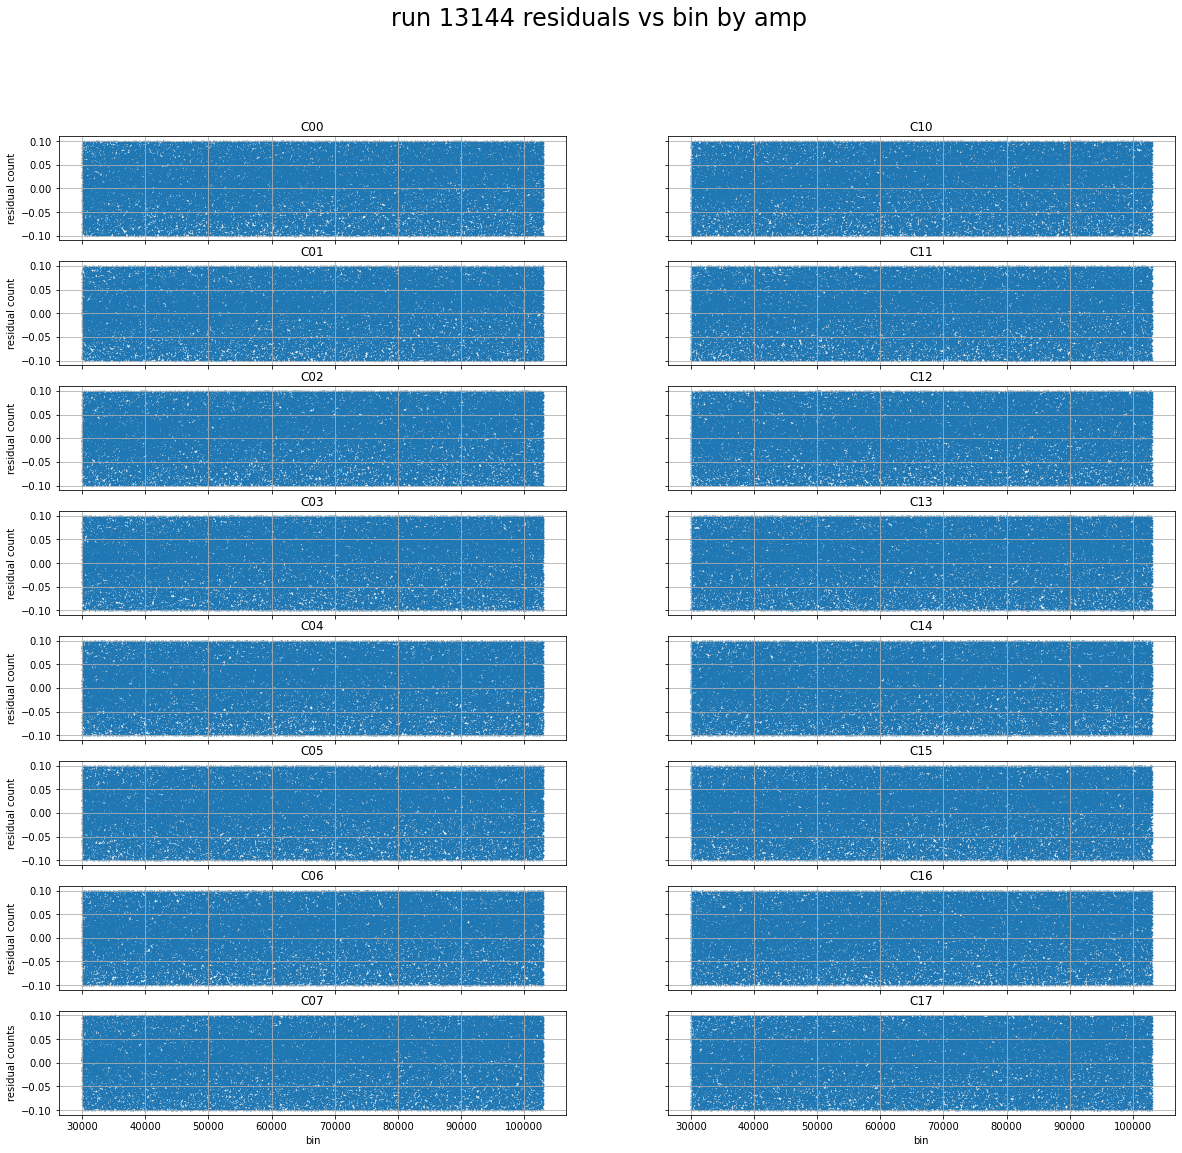

In [59]:
#plot the residuals vs bin 

fig = plt.figure(figsize=(20,18))
axes = fig.subplots(8,2, sharex=True, sharey=True)
fig.suptitle('run 13144 residuals vs bin by amp', fontsize=24)
plt.setp(axes[7,0], xlabel = 'bin', ylabel = 'residual counts') #fix the labels so on all of them 
plt.setp(axes[7,1], xlabel = 'bin')
a = 0
b = 0 
c = 0 
while c < 7: 
    plt.setp(axes[c,0], ylabel = 'residual count')
    c += 1 
for amp in amplist: 
    residuals = resids[amp]
    ### plot the residuals 
    axes[a,b].scatter(np.arange(30000, 30000+len(residuals)), residuals, s=0.3)
    axes[a,b].set_title(f"{amp}")
    axes[a,b].grid()
    if a < 7: 
        a +=1 
    else: 
        b +=1 
        a = 0

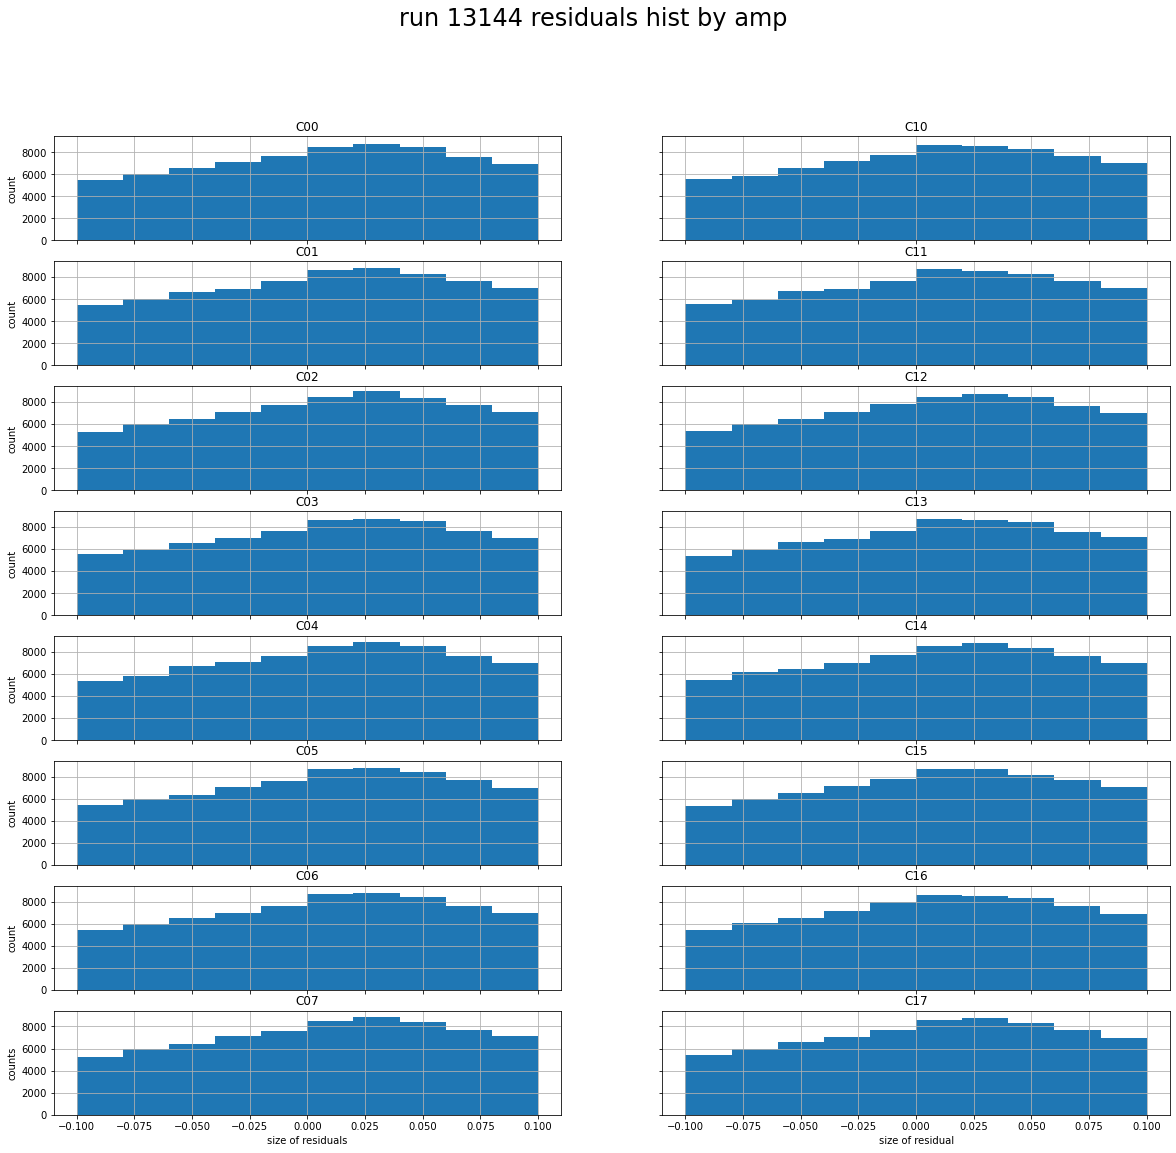

In [60]:
#plot the residuals as hist
fig = plt.figure(figsize=(20,18))
axes = fig.subplots(8,2, sharex=True, sharey=True)
fig.suptitle('run 13144 residuals hist by amp', fontsize=24)
plt.setp(axes[7,0], xlabel = 'size of residuals', ylabel = 'counts') #fix the labels so on all of them 
plt.setp(axes[7,1], xlabel = 'size of residual')
a = 0
b = 0 
c = 0 
while c < 7: 
    plt.setp(axes[c,0], ylabel = 'count')
    c += 1 
for amp in amplist: 
    residuals = resids[amp]
    ### plot the residuals 
    axes[a,b].hist(residuals)
    axes[a,b].set_title(f"{amp}")
    axes[a,b].grid()
    if a < 7: 
        a +=1 
    else: 
        b +=1 
        a = 0